# Airtraffic Management through Gate-Based Quantum Computing


By Jonathan Günther

Based on https://arxiv.org/abs/1711.04889 and https://youtu.be/yvseqXs0wKg

In collaboration with [Jan Lahmann](http://twitter.com/JanLahmann), [David Mesterhazy](https://de.linkedin.com/in/david-mesterhazy-12516427), [Tobias Stollenwerk](https://www.dlr.de/sc/en/desktopdefault.aspx/tabid-1192/1635_read-29629/sortby-lastname/), and [Stefan Wörner](https://researcher.watson.ibm.com/researcher/view.php?person=zurich-wor)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from qiskit.tools.visualization import plot_histogram

from qiskit import BasicAer
from qiskit.aqua.operators import WeightedPauliOperator as Operator
from qiskit.quantum_info import Pauli
from qiskit.aqua.components.variational_forms import RYRZ, RY
from qiskit.aqua.components.optimizers import SPSA, COBYLA
from qiskit.aqua.algorithms import ExactEigensolver, QAOA, VQE

from random import randint
import pprint
pp = pprint.PrettyPrinter(indent = 4)

import random

import math

import networkx as nx

# import QUBO generator
from create_random_instances import create_instances

import itertools

from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput

# jupyter formatting
# from IPython.display import Markdown, display
# def printmd(string):
#     display(Markdown(string))

## Load Backends

This requires to have an API key generated from https://quantum-computing.ibm.com/account

In [24]:
# uncomment below if you run the script for the first time
# IBMQ.save_account("YOUR TOKEN FROM THE LINK ABOVE")

localsim = BasicAer.get_backend('qasm_simulator')

IBMQ.load_accounts()

large_backend = IBMQ.get_backend("ibmq_16_melbourne")
onlinesim = IBMQ.get_backend("ibmq_qasm_simulator")
least_busy = least_busy(IBMQ.backends(simulator = False))

AttributeError: 'IBMQFactory' object has no attribute 'load_accounts'

## Defining the Problem

Overall cost function to be solved: $D=\sum_{i=1}^{N_f}d_i\text{ } \forall i \in N_f,\min(D)$

Conflict definition:
$B_k = [\Delta_{k}^{\min},\Delta_{k}^{\max}] \\ \Delta_{k}^{min} = 1- \Delta_t + \min\limits_{(s,t) \in T_k}\{t-s\} \\ \Delta_{k}^{max} = \Delta_t -1 + \max\limits_{(s,t) \in T_k}\{t-s\}$

with following constraints: $d_i-d_j \not\in B_k \text{ } \forall i,j \in N_f,\forall k \in N_c$

## QUBO Definition

### Base QUBO

$f_{encoding} = \lambda_{encoding} \sum_{i=1}^{N_f} (\sum_{l=0}^{N_d} d_{i,l}-1)^2$

$f_{delay} = \Delta_d \sum_{i=1}^{N_f}\sum_{l=0}^{N_d}ld_{i,l}$

$f_{conflict} = \lambda_{conflict} \sum_{k} \sum_{\substack{l-l' | \Delta_d (l,l') \in B_k \\ i,j \in I_k | i<j}} d_{i,l}d_{j,l'}$ 

$f = f_{encoding} + f_{delay} + f_{conflict}$

**Issue: QUBO needs to be flattened** 

### Flattened QUBO

$i$ and $l$ will be flattened to $m$:

$m = m(i,l) = (i-1)(N_d+1)+(l+1)$

$l_m = l(m) = m-1\mod(N_d+1)$

$i_m = i(m) = \left \lceil{\dfrac{m}{N_d+1}}\right \rceil$

Therefore $d_{i,l}$ will be transformed to

$d_i = d_{i_m}$

$d_{i_m} = l_m\Delta_d$

$d_m = \begin{cases}
    0, & \text{if } d_{i_m} \neq l_m\Delta_d\\
    1, & d_{i_m} = l_m\Delta_d
  \end{cases}$

### Mapping $d_m$ to Pauli $Z_m$

$d_m = \dfrac{1}{2}(1-Z_m) \text{ with }  Z_m = \begin{cases}
    -1, & \text{if } d_m = 1\\
    +1, & d_m = 0
  \end{cases}$
  
### - $f_{encoding}$ -
$f_{encoding} = \sum_{m,n=1}^N(d_m-\dfrac{N_f}{N})\delta_{i_m,j_n}(d_{n}-\dfrac{N_f}{N}) \text{ with } \delta_{i,j} = \begin{cases}
    0, & \text{if } i\neq j\\
    1, & i=j
  \end{cases}$
  
$f_{encoding} =   \sum_{m,n=1}^N \delta_{i_m,j_n}(\dfrac{1}{2}(1-Z_m)-\dfrac{N_f}{N})(\dfrac{1}{2}(1-Z_n)-\dfrac{N_f}{N})$

$f_{encoding} =   \sum_{m,n=1}^N \delta_{i_m,j_n}\dfrac{1}{4}(1-Z_m-\dfrac{2 N_f}{N})(1-Z_n-\dfrac{2 N_f}{N})$

$f_{encoding} =   \sum_{m,n=1}^N \delta_{i_m,j_n}\dfrac{1}{4}(c-Z_m)(c-Z_n)$

$f_{encoding} =   \dfrac{1}{4}\sum_{m,n=1}^N \delta_{i_m,j_n}(c^2-cZ_m-cZ_n+Z_mZ_n)$

with $ c = 1-\dfrac{2 N_f}{N}$

$f_{encoding} =   \dfrac{1}{4}\sum_{m,n=1}^N \delta_{i_m,j_n}(\left(1-\dfrac{2 N_f}{N}\right)^2-\left(1-\dfrac{2 N_f}{N}\right)Z_m-\left(1-\dfrac{2 N_f}{N}\right)Z_n+Z_mZ_n)$

### - $f_{deleay}$ -

$f_{delay} = \dfrac{1}{d_{\max}}\sum_{m=1}^Nl_md_m$

$f_{delay} = \dfrac{1}{2 d_{\max}}\sum_{m=1}^Nl_m(1-Z_m)$

$f_{delay} = \dfrac{1}{2 d_{\max}}\sum_{m=1}^Nl_m - \dfrac{1}{2 d_{\max}}\sum_{m=1}^Nl_mZ_m$

### - $f_{conflict}$ -

$f_{conflict} = \sum_k\sum_{m,n=1}^N(d_md_n\delta_{(l_m-l_n)\Delta_d\in B_k}\delta_{i_m\in I_k}\delta_{j_n\in I_k}\delta_{i_m<j_b}) = \sum_k\sum_{m,n=1}^N\dfrac{1}{4}\left((Z_mZ_n-Z_m-Z_n+1)\delta_{(l_m-l_n)\Delta_d\in B_k}\delta_{i_m\in I_k}\delta_{j_n\in I_k}\delta_{i_m<j_n}\right)$

$\text{ with } \delta_{(l_m-l_n)\Delta_d\in B_k} = \begin{cases}
    0, & \text{if } (l_m-l_n)\Delta_d\not\in B_k\\
    1, & (l_m-l_n)\Delta_d\in B_k
  \end{cases}$
  
$\text{ with } \delta_{i_m\in I_k} = \begin{cases}
    0, & \text{if } i_m\not\in I_k\\
    1, & i_m\in I_k
  \end{cases}$
  
$\text{ with } \delta_{i_n\in I_k} = \begin{cases}
    0, & \text{if } i_n\not\in I_k\\
    1, & i_n\in I_k
  \end{cases}$

$\text{ with } \delta_{i_m<j_b} = \begin{cases}
    0, & \text{if } i_m>=j_b\\
    1, & i_m<j_b
  \end{cases}$

### Final QUBO with mapped Pauli Z Operator

$f_{encoding} =   \dfrac{1}{4}\sum_{m,n=1}^N \delta_{i_m,j_n}(\text{const}-\left(1-\dfrac{2 N_f}{N}\right)Z_m-\left(1-\dfrac{2 N_f}{N}\right)Z_n+Z_mZ_n)$

$f_{delay} = \text{const} - \dfrac{1}{2 d_{\max}}\sum_{m=1}^Nl_mZ_m$

$f_{conflict}=\sum_k\sum_{m,n=1}^N\dfrac{1}{4}\left((Z_mZ_n-Z_m-Z_n+const)\delta_{(l_m-l_n)\Delta_d\in B_k}\delta_{i_m\in I_k}\delta_{j_n\in I_k}\delta_{i_m<j_n}\right)$

## Final Ising Hamiltonian

Generelle Form: $\hat{\mathcal H}_b = \sum_{i,j=1}^{N}J_{i,j}\hat{Z}_i\hat{Z}_j + \sum_{i}^Nh_i\hat{Z}_i$

**Einsetzen des Qubo:**

$J_{m,n} = \dfrac{1}{4}\delta_{i_m,j_n} + \dfrac{1}{4}\delta_{i_m\in I_k}\delta_{j_n\in I_k}\delta_{i_m<j_n}$

$h_m = -\dfrac{1}{4}\sum_n\left(\left(1-\dfrac{2N_f}{N}\right)(\delta_{i_m,j_n}+\delta_{i_m,j_n})+ \sum_k\left(\delta_{i_m\in I_k}\delta_{j_n\in I_k}\delta_{i_m<j_j} + \delta_{i_n\in I_k}\delta_{j_m\in I_k}\delta_{i_m<j_n}\right)\right)-\dfrac{1}{2d_{\max}}l_m$

## Setting the Constants

In [6]:
# set number of available qubits
nbr_qubits = 6

# define departure max delay, departure delay resolution
delta_d = 1 # delay resolution
N_d = 2 # maximum delay steps
dmax = delta_d * N_d
a = [l*delta_d for l in range(N_d+1)]

# calculate max calculatable flights using given number of qubits
N_f = int(nbr_qubits / (N_d + 1))

# setting N, a helper variable for m
N = (N_d + 1) * N_f

# set danger zones if planes come too close to each other
delta_t = 3 #minutes
delta_x = 30 #miles

# setting the penalty weights
lambda_encoding = 12
lambda_conflict = 12

## Generating Test Data
Using a script based on the conflict generator script by Tobias Stollenwerk

In [7]:
# small test instances with known solutions
instances = [{"conflicts":[(1,2)],"timeLimits":[(-1,2)]}]

In [8]:
# instance generation
instances = create_instances(Fmin=N_f,Fmax=N_f,Dmax=dmax,Dmin=dmax,dmin=delta_d,dmax=delta_d,repetitions=1,Tmin=dmax+delta_d,Tmax=dmax+delta_d,tmin=delta_d,tmax=delta_d)
pp.pprint(instances)

Calculate 1 instances


KeyboardInterrupt: 

In [9]:
# assign instance to variable Ik
Ik = {instances[0]["conflicts"][index]:(bk[0],bk[1]) for index,bk in enumerate(instances[0]["timeLimits"])}
# check if defined instance is valid
for el,bk in Ik.items():
    if el[0] > N_f or el[1] > N_f or el[0] > el[1]:
        print("Invalid conflict pair:",el)
    elif (bk[0] >= dmax and bk[1] <= -1*dmax) or (bk[1] >= dmax and bk[0] <= -1*dmax) or bk == (0,0) or bk[0] > bk[1]:
        print("Invalid Bk:",bk,"for conflict pair", el)

### Visualizing the Problem Instance

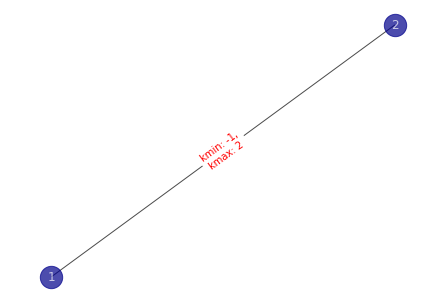

In [10]:
G=nx.Graph()
G.add_nodes_from(range(1,N_f))
G.add_edges_from([el for el,bk in Ik.items()])
pos = nx.spring_layout(G,k=0.65,iterations=20)
nx.draw(G,pos,edge_color='black',width=1,linewidths=1,\
node_size=500,node_color='darkblue',alpha=0.7,\
labels={node:node for node in G.nodes()},font_color="white")
nx.draw_networkx_edge_labels(G,pos,edge_labels={el:"kmin: "+str(bk[0])+",\nkmax: "+str(bk[1]) for el,bk in Ik.items()},font_color='red')
plt.axis('off')
plt.show()

## Ising Function
By [David Mesterhazy](https://de.linkedin.com/in/david-mesterhazy-12516427)

In [15]:
def ising(nbr_qubits : int, J : dict, h : dict) -> tuple:
    pauli_string = []
    op = {'I' : [0, 0], 'X' : [0, 1], 'Y' : [1, 1], 'Z' : [1, 0]}

    for (i, j), Jv in J.items():
        assert np.mod(i-j, nbr_qubits) != 0, 'indices cannot be equal'.format(i, j)
        # intialize classical bit string that defines tensor product operator of NN term
        config = np.zeros((nbr_qubits,2))
        # following two lines defines NN term
        config[np.mod(i-1, nbr_qubits), :] = op['Z']
        config[np.mod(j-1, nbr_qubits), :] = op['Z']
        # append classical bit string to pauli_list with corresponding coefficents, here: J and h
        pauli_string.append((Jv, Pauli(np.array(config)[:,0], np.array(config)[:,1])))
        
    for i, hv in h.items():
        # intialize classical bit string that defines tensor product operator of NN term
        config = np.zeros((nbr_qubits,2)) # 2 -> anzahl der variablen (zeile,spalte)
        # following two lines defines NN term
        config[np.mod(i-1, nbr_qubits), :] = op['Z'] # setz zeile i op[z]
        # append classical bit string to pauli_list with corresponding coefficents, here: J and h
        pauli_string.append((hv, Pauli(np.array(config)[:,0], np.array(config)[:,1])))
    
    return pauli_string

## Realization of the Ising

$\hat{\mathcal H}_b = \sum_{i,j=1}^{N}J_{i,j}\hat{Z}_i\hat{Z}_j + \sum_{i}^Nh_i\hat{Z}_i$


### Defining Helper Functions

In [11]:
# helper functions to assign i(m) and l(m)
l = lambda alpha: int(np.mod(alpha-1, N_d+1))
i = lambda alpha: int(np.ceil(alpha / (N_d+1)))

delta = lambda x, y: 1 if x == y else 0

def in_range(x, list_vals):
    assert len(list_vals) > 1, "Need at least one element to compare against"
    return min(list_vals) <= x <= max(list_vals)

### Creating the magnet field h

$h_i = -\dfrac{1}{4}\sum_j\left(\left(1-\dfrac{2N_f}{N}\right)(\delta_{i_i,j_j}+\delta_{i_j,j_i})+ \sum_k\left(\delta_{i_i\in I_k}\delta_{j_j\in I_k}\delta_{i_i<j_j} + \delta_{i_j\in I_k}\delta_{j_i\in I_k}\delta_{i_j<j_i}\right)\right)-\dfrac{1}{2d_{\max}}l_i$

In [12]:
# partial magnet fields
h_delay = { alpha : -1/2 * delta_d * l(alpha) for alpha in range(1, N+1) }
h_encoding = { alpha : 2 * lambda_encoding * 
              sum([-1/4 * (1 - 2 * N_f / N ) * delta(i(alpha), i(beta)) for beta in range(1, N+1)])
              for alpha in range(1, N+1) }
h_conflict = { alpha : lambda_conflict * (-1/4 * sum([1 
                                                     for beta in range(1, N+1)
                                                     for k in range(len(Ik))
                                                     if ((i(alpha) < i(beta)) and
                                                     (True if i(alpha) in list(Ik.keys())[k] else False) and
                                                     (True if i(beta) in list(Ik.keys())[k] else False) and
                                                     in_range((l(alpha) - l(beta)) * delta_d, list(Ik.values())[k]))]) +
                                          -1/4 * sum([1
                                                     for beta in range(1, N+1)
                                                     for k in range(len(Ik)) 
                                                     if ((i(beta) < i(alpha)) and
                                                     (True if i(alpha) in list(Ik.keys())[k] else False) and
                                                     (True if i(beta) in list(Ik.keys())[k] else False) and
                                                     in_range((l(beta) - l(alpha)) * delta_d, list(Ik.values())[k]))]))
              for alpha in range(1, N+1) }

# fuse magnet fields
h = { alpha : h_delay[alpha] + 
              h_encoding[alpha] + 
              h_conflict[alpha] for alpha in range(1, N+1) }
h = { k:v for k,v in h.items() if v != 0 }
pp.pprint(h)

{1: -12.0, 2: -15.5, 3: -16.0, 4: -15.0, 5: -15.5, 6: -13.0}


### Creating the Couplings J

$J_{i,j} = \dfrac{1}{4}\delta_{i_m,j_n} + \dfrac{1}{4}\delta_{i_m\in I_k}\delta_{j_n\in I_k}\delta_{i_m<j_n}$

In [13]:
# partial couplings
J_delay = {}
J_encoding = { (alpha, beta) : 2 * 1/4 * lambda_encoding * delta(i(alpha), i(beta))
             for alpha in range(1, N+1)
             for beta in range(1, N+1) 
             if alpha < beta}
J_conflict = { (alpha, beta) : 1/4 * lambda_conflict * (sum([1 for k in range(len(Ik)) 
                                                            if (i(alpha) < i(beta)) and
                                                            (True if i(alpha) in list(Ik.keys())[k] else False) and
                                                            (True if i(beta) in list(Ik.keys())[k] else False) and
                                                            (in_range((l(alpha) - l(beta)) * delta_d, list(Ik.values())[k]))]))
             for alpha in range(1, N+1)
             for beta in range(1, N+1) 
             if alpha != beta }

# fusing the partial couplings
J = { (alpha, beta) : (J_delay[(alpha, beta)] if (alpha, beta) in J_delay.keys() else 0) + 
                      (J_encoding[(alpha, beta)] if (alpha, beta) in J_encoding.keys() else 0) +
                      (J_conflict[(alpha, beta)] if (alpha, beta) in J_conflict.keys() else 0)
     for alpha in range(1, N+1)
     for beta in range(1, N+1)
    }
J = { k:v for k,v in J.items() if v != 0 }
pp.pprint(J)

{   (1, 2): 6.0,
    (1, 3): 6.0,
    (1, 4): 3.0,
    (1, 5): 3.0,
    (2, 3): 6.0,
    (2, 4): 3.0,
    (2, 5): 3.0,
    (2, 6): 3.0,
    (3, 4): 3.0,
    (3, 5): 3.0,
    (3, 6): 3.0,
    (4, 5): 6.0,
    (4, 6): 6.0,
    (5, 6): 6.0}


### Creating the Hamiltonian and preparing it for Qiskit algorithms

In [20]:
ham = ising(J = J, h = h, nbr_qubits = nbr_qubits)
# pp.pprint(ham)
# builtin qiskit function
op = Operator(ham)

### Calculate the solution using a classical eigensolver

In [21]:
# ee solver
eig = ExactEigensolver(op)
result = eig.run()
output = {}

# debugging
print("--constants:--")
print("N_f:", N_f)
print("N_d:", N_d)
print("N:", N)
print("qubits: ", nbr_qubits)
print("dmax:", dmax)
print("delta_d:", delta_d)

print("")

print("--conflicts:--")
for item,bk in Ik.items():
    print("flights: ", item, "Bk:", bk)
print("")

ee = np.where(result["eigvecs"][0] == 1)
m =ee[0][0] +1
bit = "{0:b}".format(ee[0][0])
for item in range(nbr_qubits - len(bit)):
    bit = "0" + bit
print("--ee solution: " + bit + " (position " + str(m) + ")--")

for index,m in enumerate(bit[::-1]):
    alpha = index+1
    if m == "1":
        print("flight:",int(i(alpha)),"| delay:",l(alpha)*delta_d,"| m =",alpha,[''," --> ERROR"][int(i(alpha)) in output])
        output[int(i(alpha))] = l(alpha)*delta_d
print("")

for item,bk in Ik.items():
    if bk[0] <= output[item[0]]-output[item[1]] <= bk[1]:
        print("solultion for",item, "(di-dj:",output[item[0]]-output[item[1]],") is conflicting: element in bk:",bk[0],"<=",output[item[0]]-output[item[1]],"<=",bk[1])

print("")

print("--raw output of ee solver--")
pp.pprint(result)

# visualize m
# n = 1 
# a = np.zeros(shape=(N_f,N_d+1))
# for index,row in enumerate(a):
#     for s in range(0,len(a[index])):
#         a[index][s] = n
#         n += 1

# plt.figure(figsize=(5,5))
# plt.title("m Matrix")
# tb = plt.table(cellText=a, loc=(0,0), cellLoc='center',colLabels=[n for n in range(0,delta_d,N_d)],rowLabels=[n for n in range(1,N_f+1)])

# tc = tb.properties()['child_artists']
# for cell in tc: 
#     cell.set_height(.4/N_f)
#     cell.set_width(.4/N_d)

# for cell in tc:
#     print(cell)
    
# for (row,col), cell in tb.get_celld().items():
#     if (row == 0) or (col == -1):
#         cell.set_linewidth(0)
#         cell.set_text_props(fontproperties=FontProperties(weight='bold'))

# ax = plt.gca()
# ax.set_xticks([])
# ax.set_yticks([])
# # ax.axis('off')

# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# ax.spines["left"].set_visible(False)
# ax.spines["bottom"].set_visible(False)

# plt.ylabel('flights i')
# plt.xlabel('delay step d')


--constants:--
N_f: 2
N_d: 2
N: 6
qubits:  6
dmax: 2
delta_d: 1

--conflicts:--
flights:  (1, 2) Bk: (-1, 2)

--ee solution: 100001 (position 34)--
flight: 1 | delay: 0 | m = 1 
flight: 2 | delay: 2 | m = 6 


--raw output of ee solver--
{   'eigvals': array([-49.+0.j]),
    'eigvecs': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
    'energies': array([-49.]),
    'energy': -49.0,
    'wavefunction': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}


### Calculate the solution using given quantum algorithm on IBM Q

In [25]:
# TODO: Optimize Algorithms

# comment if you do not want to use VQE
optimizer = SPSA(max_trials=500)
q = VQE(op, optimizer = optimizer, var_form = RYRZ(nbr_qubits))

# the algorithm below is faster but may not be accurate for sizes > 4 qubit in its current state
# optimizer = COBYLA(maxiter = 100)
# q = VQE(op, optimizer = optimizer, var_form = RYRZ(nbr_qubits), operator_mode = 'paulis')

# uncomment if you want to use QAOA instead
# optimizer = COBYLA(maxiter = 10)
# depth = 2
# q = QAOA(op, optimizer, p = depth, operator_mode = 'paulis')

# calculate the problem
results = q.run(localsim) # options: localsim,onlinesim,largebackend,least_busy

# Sometimes results are not correct and it may needs to calculate the problem several times
# iterations = 10 # change this for how often the problem is calculated
# result_collection = []
# highest = []
# result_collection = {}
# for n in range(iterations):
#     print(n+1,". calculation")
#     results = q.run(localsim) # options: localsim,onlinesim,largebackend,least_busy
#     result_collection[n+1] = results
#     highest.append(max(results["eigvecs"][0].keys(), key=(lambda key: results["eigvecs"][0][key])))

# print("- done -")

### Plot the Results

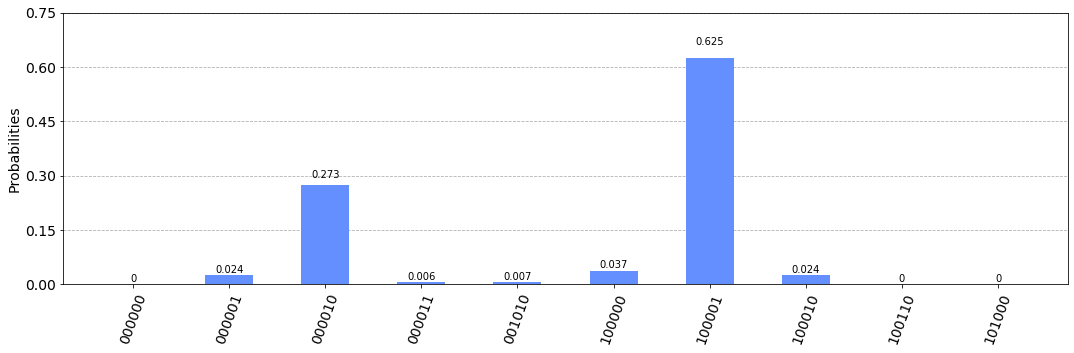

In [26]:
# Plot the results for a single calculation
plot_histogram(results['eigvecs'], figsize = (18,5))

# # Plot the results for multiple calculations
# chart = {}
# for n in highest:
#     if not n in chart:
#         chart[n] = 0
#     chart[n] += 1
# plot_histogram(chart, figsize = (18,5),title="Most likely result after "+str(iterations)+" calculations")
# # pp.pprint(result_collection)